In [1]:
import random
import numpy as np
import torch
import torch

# multivariate data preparation
from numpy import array
from numpy import hstack
import matplotlib.pyplot as plt

import joblib 
from torch import nn

In [2]:
data = np.loadtxt('./data/tower_prep_data2.csv', delimiter=',', dtype=np.float32, skiprows=1)

In [3]:
train_window = 5000
offset = 0

In [4]:
dataset = data[: - train_window, 4:]

In [5]:
from sklearn.preprocessing import MinMaxScaler

#scaler3 = MinMaxScaler(feature_range=(-1, 1))
#vibrations = scaler3.fit_transform(dataset[:, 0] .reshape(-1, 1))

scaler4 = MinMaxScaler(feature_range=(-1, 1))
temperature = scaler4.fit_transform(dataset[:, 0] .reshape(-1, 1))

scaler6 = MinMaxScaler(feature_range=(-1, 1))
temperature_pir = scaler6.fit_transform(dataset[:, 1] .reshape(-1, 1))

scaler7 = MinMaxScaler(feature_range=(-1, 1))
start_stop = scaler7.fit_transform(dataset[:, 2] .reshape(-1, 1))

In [5]:
for x in range(len(temperature)):
    dataset[x] = [temperature[x][0], temperature_pir[x][0], start_stop[x][0]]

NameError: name 'temperature' is not defined

In [6]:
scaler_vibrations = joblib.load('./scalers/motor2.gz')
scaler_temperature = joblib.load('./scalers/temperature.gz')
scaler_start_stop = joblib.load('./scalers/start_stop.gz')

In [7]:
#vibrations = scaler_vibrations.transform(np.log( dataset[offset:, 0] + 1e-15).reshape(-1, 1))
temperature = scaler_temperature.transform(dataset[offset:, 0] .reshape(-1, 1))
start_stop = scaler_start_stop.transform(dataset[:, 2] .reshape(-1, 1))
#temperature_pir = scaler_temperature_pir.transform(dataset[offset:, 2] .reshape(-1, 1))
#temperature = dataset[offset:, 1]/100
temperature_pir = dataset[offset:, 1]/50

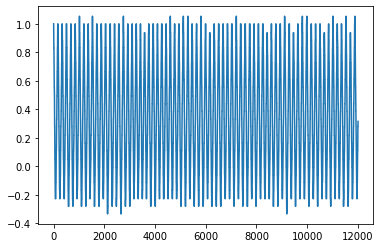

In [17]:
plt.plot(temperature)

In [8]:
print(temperature_pir)

[0.4638     0.4638     0.4638     ... 0.48119998 0.48119998 0.48119998]


In [18]:
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        
        super(NeuralNetwork, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
        
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 6)
        )
        
    
    def forward(self, x):
        
        output = self.linear_relu_stack(x)
        return output

In [19]:
motor_model = torch.load("./models/motor2.pt")

In [20]:
def motor_eval(vib):
    motor_model.eval()

    with torch.no_grad():

        outputs = torch.tensor(vib.reshape(-1, 60))

        outputs = motor_model(outputs)
        _, predicted = torch.max(outputs, 1)
        
        return predicted.item()

In [21]:
dataset = np.stack((temperature[60:, 0], temperature_pir[60:], start_stop[60:, 0]), axis=1)
#dataset = temperature[:, 0]

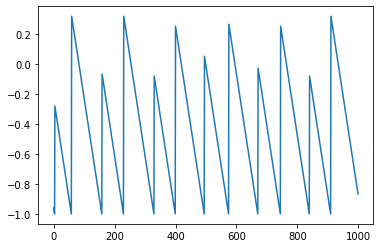

In [22]:
#plt.plot(dataset[:1000, 2])
plt.plot(start_stop[:1000, 0])
plt.show()

In [23]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 20 # number of hidden states
        self.n_layers = 4 # number of LSTM layers (stacked)
    
        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 1)
        
    
    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)
    
    
    def forward(self, x):        
        batch_size, seq_len, _ = x.size()
        
        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.l_linear(x)

In [24]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences) - 1):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences) - 1:
            break
        
        
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [25]:
dataset

array([[-0.11111069,  0.4638    ,  0.30666673],
       [-0.11111069,  0.4638    ,  0.2933334 ],
       [-0.16888809,  0.4638    ,  0.27999997],
       ...,
       [ 0.2800026 ,  0.48119998, -0.5333333 ],
       [ 0.297781  ,  0.48119998, -0.5466666 ],
       [ 0.31555557,  0.48119998, -0.56      ]], dtype=float32)

(11891, 60, 2) (11891,)
step :  0 loss :  0.10853230208158493
step :  1 loss :  0.10629866272211075
step :  2 loss :  0.1059766486287117
step :  3 loss :  0.10027612745761871
step :  4 loss :  0.06475184857845306
step :  5 loss :  0.053903866559267044
step :  6 loss :  0.026727715507149696
step :  7 loss :  0.024365929886698723
step :  8 loss :  0.023126665502786636
step :  9 loss :  0.022507179528474808
2


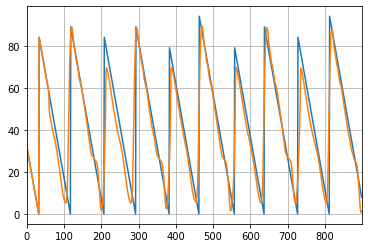

3


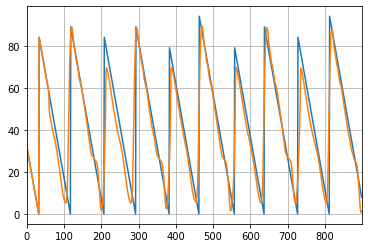

4


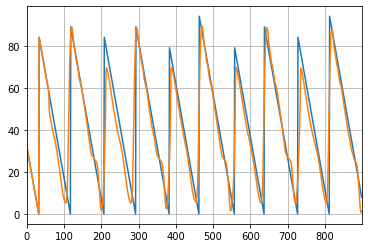

5


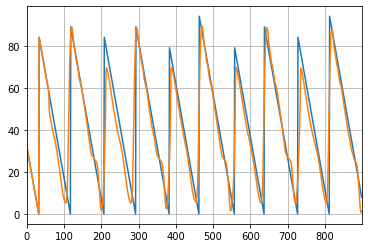

6


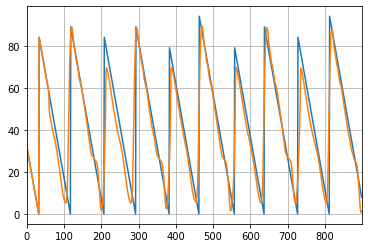

7


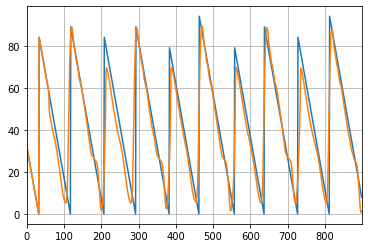

8


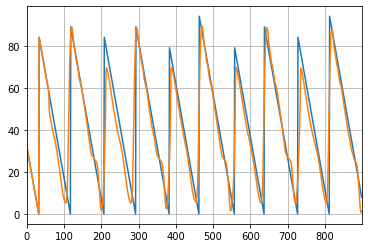

9


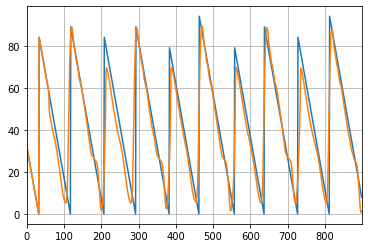

10


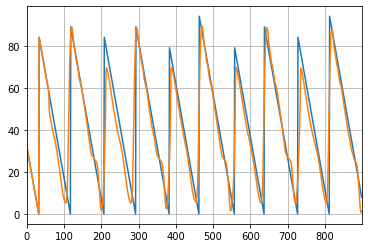

11


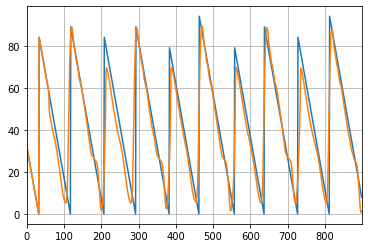

In [27]:
n_features = 2 # this is number of parallel inputs
n_timesteps = 60 # this is number of timesteps

# convert dataset into input/output
X, y = split_sequences(dataset, n_timesteps)
print(X.shape, y.shape)

# create NN
mv_net = MV_LSTM(n_features,n_timesteps)
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=0.001)

train_episodes = 10
batch_size = 500

accuracy = 1

while(accuracy < 3):
    
    mv_net.train()
    for t in range(train_episodes):
        for b in range(0,len(X),batch_size):
            inpt = X[b:b+batch_size,:,:]
            target = y[b:b+batch_size]    

            x_batch = torch.tensor(inpt,dtype=torch.float32)    
            y_batch = torch.tensor(target,dtype=torch.float32)
            #print(x_batch)
            mv_net.init_hidden(x_batch.size(0))
        #    lstm_out, _ = mv_net.l_lstm(x_batch,nnet.hidden)    
        #    lstm_out.contiguous().view(x_batch.size(0),-1)
            output = mv_net(x_batch) 
            loss = criterion(output.view(-1), y_batch)  

            loss.backward()
            optimizer.step()        
            optimizer.zero_grad() 
        print('step : ' , t , 'loss : ' , loss.item())
    
    
    
    for k in range(10):
    
        #train_window = (k + 1) * 1000

        fut_pred = 900

        dataset_test = data[-train_window:, 4:].copy()#.tolist()
        dataset_test_l = data[-train_window:, 4:].tolist()
        


        #vibrations = scaler3.transform(dataset[:, 0] .reshape(-1, 1))
        #temperature = scaler4.transform(dataset_test[:, 0] .reshape(-1, 1))
        #temperature_pir = scaler6.transform(dataset_test[:, 1] .reshape(-1, 1))
        #start_stop = scaler7.transform(dataset[:, 2] .reshape(-1, 1))

        #for x in range(len(temperature)):
        #    dataset_test[x] = [temperature[x][0], temperature_pir[x][0], start_stop[x][0]]
        
        #vibrations = scaler_vibrations.transform(np.log( dataset_test[:, 0] + 1e-15).reshape(-1, 1))
        
        temperature = scaler_temperature.transform(dataset_test[:, 0] .reshape(-1, 1))
        start_stop = scaler_start_stop.transform(dataset_test[:, 2] .reshape(-1, 1))
        temperature_pir = dataset_test[offset:, 1]/50
        
        #for x in range(len(temperature)):
            #dataset_test[x] = [vibrations[x][0], temperature[x][0], temperature_pir[x][0]]
         #   dataset_test[x] = [temperature[x][0], temperature_pir[x][0]]

        dataset_test = []

        #for x in range(len(temperature)):
        #    dataset_test.append([temperature[x][0], temperature_pir[x][0]])

        #dataset_test = np.array(dataset_test)
        pred_vibrations = np.empty(temperature.size)
        pred_vibrations.fill(motor_eval(vibrations[:60])/5)

        pred_temperature = np.empty(temperature.size)
        pred_temperature.fill( temperature_pir[0] )

        dataset_test = np.stack((temperature[:, 0], pred_temperature[:], start_stop[:, 0]), axis=1)


        mv_net.eval()

        for i in range(fut_pred):

            seq = torch.FloatTensor([ dataset_test[i: i + n_timesteps, :-1]])
            #print(seq)

            with torch.no_grad():

                mv_net.init_hidden(seq.size(0))
                dataset_test[i + n_timesteps] = [dataset_test[i + n_timesteps][0], dataset_test[i + n_timesteps][1], mv_net(seq).item()]
                #print(dataset_test[i])
                #print(mv_net(seq).item())


        dataset_test = torch.FloatTensor(dataset_test)
        dataset_test_l = torch.FloatTensor(dataset_test_l)
        temp = scaler_start_stop.inverse_transform(np.array(dataset_test[:fut_pred, 2] ).reshape(-1, 1))


        suma = 0
        for i in range(fut_pred):

            suma += abs(dataset_test_l[i, 2] - temp[i]) / dataset_test_l[i, 2]

        accuracy += 1 #suma / fut_pred
        print(accuracy)

        plt.grid(True)
        plt.autoscale(axis='x', tight=True)
        plt.plot(dataset_test_l[:fut_pred, 2])
        plt.plot(temp)
        #plt.plot(dataset_test[:fut_pred, 1])
        #plt.plot(temperature[:fut_pred])
        plt.show()

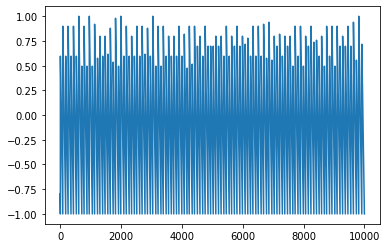

In [29]:
plt.plot( start_stop )

In [10]:
torch.save(mv_net, "./models/start_stop.pt")

In [28]:
torch.save(mv_net, "./models/start_stop2.pt")

In [11]:
#joblib.dump(scaler3, './scalers/vibrations.gz')
joblib.dump(scaler4, './scalers/temperature.gz')
joblib.dump(scaler6, './scalers/temperature_pir.gz')
joblib.dump(scaler7, './scalers/start_stop.gz')

['./scalers/start_stop.gz']